In [1]:
from fastai.vision.all import *

In [2]:
PATH = Path('../input/optiver-realized-volatility-prediction')

# data_df = pd.read_parquet(PATH/'book_train_reindexed.parquet')

# sizes = ['bid_size1', 'bid_size2', 'ask_size1', 'ask_size2']
# for sz in sizes:
#     data_df[sz] = data_df[sz]/ 1_000_000



In [3]:
#train_df = pd.read_csv(PATH/'train_with_offset.csv')
# data_df['wap'] = (data_df.bid_price1 * data_df.ask_size1 + data_df.ask_price1 * data_df.bid_size1) / (data_df.ask_size1 + data_df.bid_size1)

# mean_wap =[]
# for row in train_df.itertuples():
#     df = data_df.iloc[row.offset:row.offset+600]
#     mean_wap.append(df.wap.mean())

In [4]:
# train_df['mean_wap']=mean_wap
# train_df.to_csv(PATH/'train_with_wap.csv')

In [5]:
# np_data = data_df[['bid_price1', 'ask_price1', 'bid_size1', 'ask_size1','bid_price2', 'ask_price2', 'bid_size2', 'ask_size2']].to_numpy()

# del data_df

# np_data = np_data.astype('float32')
# torch_data = torch.tensor(np_data)

# del np_data

# torch.save(torch_data, PATH/'torch_data.pth')

In [6]:
%%time
torch_data = torch.load(PATH/'torch_data.pth')

CPU times: user 0 ns, sys: 12 s, total: 12 s
Wall time: 1min 57s


In [7]:
#torch_data[:,[2,3,6,7]] = 1000000 * torch_data[:,[2,3,6,7]] 

In [8]:
means, stds = torch_data.mean(dim=0), torch_data.std(dim=0)
print(means, stds)
torch_data = (torch_data - means) / stds

tensor([9.9968e-01, 1.0003e+00, 7.6999e-04, 7.6673e-04, 9.9948e-01, 1.0005e+00,
        9.5934e-04, 9.2822e-04]) tensor([0.0037, 0.0037, 0.0054, 0.0050, 0.0037, 0.0037, 0.0067, 0.0057])


In [9]:
train_df = pd.read_csv(PATH/'train_with_wap.csv')

In [10]:
w = train_df.mean_wap.to_numpy()

w =np.sort(w)

bins = []

step = (len(w)+9)//10
for i in range(0, len(w), step):
    j = min(i+step, len(w))
    bins.append(w[j] if j< len(w) else 2)
    print(w[i], w[j-1],np.median(w[i:j]) )

wap_bin = np.digitize(train_df.mean_wap, bins)

train_df['wap_bin']=wap_bin

0.9172531180048944 0.9971951138775056 0.9956492523836432
0.9971951327900604 0.9984703256953886 0.9979708959569917
0.9984703751656142 0.9991431543863876 0.9988451162091514
0.9991431683337992 0.999616836138266 0.9993924853218963
0.9996168497680276 1.0000141933324718 0.9998199779860442
1.0000141975255898 1.0004091980748968 1.00020793857736
1.0004091986325243 1.000876884050013 1.0006291062379966
1.0008769297217603 1.0015230362748495 1.0011664016312456
1.0015230933064834 1.002768629281105 1.0020189286622183
1.0027686365447124 1.077264872305151 1.004330146304397


In [11]:
w = train_df.target.to_numpy()

w =np.sort(w)

bins = []
bin_med=[]
step = (len(w)+9)//10
for i in range(0, len(w), step):
    j = min(i+step, len(w))
    bins.append(w[j] if j< len(w) else 1)
    bin_med.append(np.median(w[i:j]))
    print(w[i], w[j-1],np.median(w[i:j]) )

target_bin = np.digitize(train_df.target, bins)

train_df['target_bin']=target_bin

0.000105263 0.001436988 0.001175852
0.001436991 0.001838282 0.0016455530000000001
0.001838308 0.002210492 0.0020263215
0.002210493 0.002604845 0.00240206
0.002604847 0.003048064 0.002817908
0.003048071 0.003585089 0.0033027735
0.003585105 0.00428704 0.003905317
0.004287042 0.005311553 0.0047378975
0.005311559 0.007240946 0.0060829544999999995
0.007240976 0.07032062 0.009453786499999998


In [459]:
class ResBlock(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv1d(ch, ch, kernel_size = 5, padding = 2, padding_mode='replicate'),
            nn.BatchNorm1d(ch),
            nn.ReLU(),
            nn.Conv1d(ch, ch, kernel_size = 5, padding = 2, padding_mode='replicate'),
            nn.BatchNorm1d(ch),
        )
        
    def forward(self, x):
        res = self.layers(x) + x
        res = F.relu(res)
        return res

In [460]:
class ResnetModel(nn.Module):
    def __init__(self, num_outputs, do_sigmoid = False):
        super().__init__()
        self.do_sigmoid = do_sigmoid
        chan = 32
        layers = [nn.Conv1d(8, chan, kernel_size=1)]
        
        for _ in range(8):
            layers += [ResBlock(chan), ResBlock(chan), ResBlock(chan), ResBlock(chan)
                       , nn.AvgPool1d(2, padding=1),
                      ]
        layers += [Flatten(), nn.Dropout()]   
        self.conv_layers = nn.Sequential(*layers)
        self.classifier = nn.Linear(chan*4, num_outputs)
        
    def forward(self, x):
        feat = self.conv_layers(x)
        res = self.classifier(feat)
        if self.do_sigmoid:
            res = sigmoid_range(res, 0, .1).view(-1)
        return res

In [437]:
def stock_id(row):
    return row.stock_id

In [438]:
class LoadTransform(Transform):
    def __init__(self, torch_data):
        super().__init__()
        self.data = torch_data
        
    def encodes(self, row):
        ret = self.data[row.offset:row.offset+600].T
        #return ret.view(1,600,8)
        return ret

tfm = LoadTransform(torch_data)

data_block = DataBlock(
        blocks = (TransformBlock(type_tfms=tfm), 
                  #TransformBlock(type_tfms=stock_id),
                  CategoryBlock(vocab=list(range(10)))),
        splitter=ColSplitter(),
        #get_y=ColReader('target'),
        #get_y=ColReader('wap_bin'),
        get_y=ColReader('target_bin'),
)
dls = data_block.dataloaders(train_df, bs=1024)

In [439]:
dls_reg = DataBlock(
        blocks = (TransformBlock(type_tfms=tfm), 
                  #TransformBlock(type_tfms=stock_id),
                  RegressionBlock()),
        splitter=ColSplitter(),
        get_y=ColReader('target'),
).dataloaders(train_df, bs = 1024)


In [440]:
bx,by = dls.one_batch()

In [461]:
md = ResnetModel(10).cuda()
md(bx).shape

torch.Size([1024, 10])

In [442]:
def rmspe(preds, targs):
    x = (targs-preds)/targs
    return (x**2).mean().sqrt()

In [443]:
def rmspe_loss(preds, targs, reduction='mean'):
    assert reduction == 'mean'
    x = (targs-preds)/targs
    return (x**2).mean().sqrt()

In [462]:
#learn = Learner(dls, ConvModel(),loss_func=mspe_loss, metrics=AccumMetric(rmspe))
learn = Learner(dls, ResnetModel(10), metrics = [accuracy], cbs=[MixUp])

In [463]:
learn.fit_one_cycle(12,1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.990224,1.690349,0.337753,00:53
1,1.841932,1.587530,0.380812,00:52
2,1.791866,1.578612,0.358819,00:53
3,1.775076,1.551087,0.383459,00:53
4,1.759889,1.502268,0.402220,00:53
5,1.753300,1.489773,0.412161,00:53
6,1.745365,1.538201,0.397292,00:54
7,1.731257,1.446765,0.418261,00:53
8,1.726388,1.471091,0.407612,00:58
9,1.719394,1.436002,0.418700,01:03


In [464]:
learn.save('res_model2.pth')

Path('models/res_model2.pth.pth')

In [465]:
learn.load('res_model2.pth')

#stem = nn.Sequential(*list(learn.model.layers.children())[:-1])
#stem = nn.Sequential(*list(ResnetModel(10).layers.children())[:-1])
#reg_m = ResnetRegression(stem, 6*16)
reg_m = ResnetModel(1, do_sigmoid=True)
#reg_m.initial_conv = learn.model.initial_conv
reg_m.conv_layers = learn.model.conv_layers


In [466]:
def split_2way(model):
    #return L(params(model.initial_conv)+params(model.conv_layers), params(model.classifier))
    return L(params(model.conv_layers), params(model.classifier))

In [467]:
learn2 = Learner(dls_reg, reg_m, splitter=split_2way, loss_func=rmspe_loss, metrics=AccumMetric(rmspe))#, cbs=SaveModelCallback(monitor='rmspe', comp=np.less))

In [468]:
learn2.fine_tune(12, 5e-3,freeze_epochs=3)

epoch,train_loss,valid_loss,rmspe,time
0,1.225896,0.747881,0.763144,00:54
1,0.696686,0.524205,0.527369,00:54
2,0.505249,0.317782,0.319861,00:49


epoch,train_loss,valid_loss,rmspe,time
0,0.442496,0.317466,0.319205,00:51
1,0.395814,0.256959,0.259631,00:51
2,0.351776,0.254266,0.257161,00:51
3,0.320760,0.245999,0.248620,00:51
4,0.304392,0.238491,0.241322,00:51
5,0.291607,0.250253,0.252946,00:51
6,0.283156,0.248890,0.252102,00:51
7,0.278681,0.252075,0.254741,00:49
8,0.273051,0.235022,0.237844,00:50
9,0.270609,0.240834,0.243775,00:49


In [227]:
learn2 = Learner(dls_reg, ResnetModel(1, do_sigmoid=True), splitter=split_2way, loss_func=rmspe_loss, metrics=AccumMetric(rmspe), wd=.1)

learn2.fit_flat_cos(12, 1e-3, wd=.2)

In [469]:
torch.save(learn2.model, 'resnet_model2.pth')

In [428]:
preds, targs = learn2.get_preds()

rmspe(preds.view(-1), targs)

tensor(0.2422)

In [429]:
preds, targs = learn.get_preds()

In [430]:
predicted_bins = torch.argmax(preds, dim=1)

In [431]:
CI = ClassificationInterpretation.from_learner(learn)

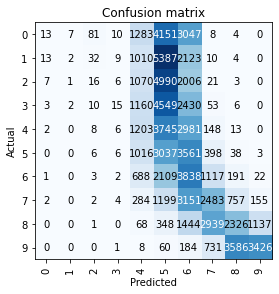

In [432]:
CI.plot_confusion_matrix()

In [433]:
pred_vals =torch.tensor(bin_med)[predicted_bins]

In [434]:
target_vals = dls.valid.items.target.to_numpy()
target_vals = torch.tensor(target_vals)

In [435]:
rmspe(pred_vals, target_vals)

tensor(0.9269, dtype=torch.float64)